<a href="https://colab.research.google.com/github/hyeonji0401/CUDA_practice/blob/main/CUDA_memory_hierarchy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 8.1 컴퓨터 시스템의 메모리 계층

보조기억장치 -> 메인 메모리 -> 캐시 -> 레지스터

-> 으로 갈수록 적은 용량, 고성능, 고가임

- 보조기억장치(auxilary memory)
 - 흔히 디스크로 부르며 데이터를 보관하기 위해 사용함
 - 컴퓨터가 데이터를 사용하기 위해서는 보조기억장치에 있는 데이터를 메인 메모리로 가지고 와야함
- 메인 메모리(main memory)
 - 연산 장치가 접근할 수 있는 가장 먼 저장장치로 연산을 위한 데이터를 보관하는 공간
 - 흔히 메모리라고 부름

**=> 보조메모리와 메인 메모리를 구분한 이유**

- 최소한의 비용으로 최대한의 효과를 얻기 위해
 - 저렴하지만 용량이 큰 보조기억장치에 모든 데이터를 보관해두고 현재 작업에 필요한 데이터만 속도가 빠른 메인 메모리에 가져와 사용하는 방법으로 용량과 속도를 둘다 잡는 전략

 - 레지스터 & 캐시
  - CPU 내부에 있는 메모리롤 메인 메모리보다 월등히 빠르지만 그만큼 비싸고 매우 작은 저장공간
  - 레지스터 : 연산 장치가 현재 수행 중인 연산을 위해 사용하는 임시 저장 공간
  - 캐시 : 자주 사용하는 데이터를 가져다 놓는 공간
  - 우리가 직접 제어할 수 없고 CPU와 같은 하드웨어에 의해 관리됨


=> GPU 메모리도 계층을 나눠놓은 이유가 유사하지만 CPU의 캐시와 달리 GPU는 특정 캐시 메모리(공유 메모리)를 직접 제어할 수 있는 특성을 가짐

# 8.2 CUDA 메모리 계층

1.스레드 수준 메모리
- 각 스레드 내부에서 사용되므로 다른 스레드에서 접근할 수 없는 메모리 공간

가. 레지스터
- CUDA 코어 연산을 위한 데이터를 담아두고 사용하는 공간
- 스레드가 연산을 위해 데이터를 저장하는 공간
- 커널 내부에서 선언된 지역 변수를 위해 사용됨
- GPU 메모리 중 가장 빠른 메모리로 일반적으로 GPU cycle보다 작은 시간 소요
- SM내부에 있어 인-코어(in-core) 메모리라고 부름
- 속도는 빠르지만 가장 크기가 작은 메모리임(블록 또는 SM하나당 8k-64k개의 32비트)

 ex) 하나의 스레드 블록 당 최대 스레드 1024개를 사용하는 경우

    - 한 스레드는 8 ~ 64개의 레지스터만 사용 가능 (8 ~ 64개의 정수형 변수,,)
- 활성 블록 수를 늘리게 되면 스레드 당 사용가능한 레지스터 수는 더 줄어들음

=> 활성 블록의 수를 2로 만들면 스레드당 할당 가능한 레지스터 수는 절반으로 줄어듦

- 실제 지역 변수의 수가 사용 가능한 레지스터 수보다 많은 경우, 어떤 지역 변수를 레지스터에 담을지 여부는 컴파일러에 의해 결정됨
- 레지스터 담지 못하는 지역 변수는 지역 메모리에 할당됨

2. 지역 메모리
- SM 밖에 있는 오프-칩(off-chip) 메모리임
- 접근 속도는 400 ~ 600 GPU cycle정도로 레지스터보다 느리지만 사용 가능한 메모리 공간이 큼
- GPU 디바이스 메모리(DRAM: GPU사양에서 말하는 '메모리'를 의미함) 공간 일부가 지역 메모리로 사용됨
- 전역 메모리 또한 디바이스 메모리 영역을 사용하지만 지역 메모리는 각 스레드가 자신만의 공간을 갖는다는 점에서 전역메모리와 구분됨
- 레지스터를 사용하기에는 큰 구조체나 배열 등이나 일반 변수이지만 레지스터 공간을 할당 받지 못할 경우 지역 메모리 공간을 사용함
(스레드당 512KB 제한이 있지만 스레드 하나가 지역 변수를 사용하기에는 충분함)



2.블록 수준 메모리
- 모든 스레드가 접근할 수 있는 공유 메모리 공간
- 1~4 GPU cycle 정도로 속도가 빠른 온-칩 메모리임
- 디바이스 메모리보다 작으며 compute capability에 따라 SM당 16~96kb의 크기를 가짐
- 공유 메모리 공간을 어떻게 사용하느냐에 따라 CUDA 프로그램 성능이 수 배 빨라질 수 있음 따라서 해당 메모리 공간의 크기를 아는 것이 중요함
- 블록 내 모든 스레드가 공동으로 자주 사용하는 데이터를 보관함으로써 메모리 공간을 절약함과 동시에 데이터 접근 속도를 높일 수 있음
- SM 내 공유 메모리 공간은 해당 SM을 사용하는 스레드 블록들이 나누어서 사용하므로 하나의 스레드 블록에서 사용하는 공유 메모리 공간의 크기는 활성 블록의 수에 영향을 줌
- 공유 메모리를 사용하는 방법은 크게 3가지로 9장에서 나올 예정
 - 사용자가 직접 관리하는 사용자 관리 캐시 형태 사용법
   - 공유 메모리를 __shared__지시어를 통해 명시적으로 선언 및 할당
   - 정적할당과 동적할당 방법으로 할당받을 수 있음

가. 정적 할당(static allocation)


```
__global__ void kernel(void)
{
  __shared__ int sharedMemory[512];
}
```
- 커널 내부에서 공유 메모리 공간을 선언 및 할당하는 방법
- '__ shared __'가 붙은 변수 선언의 경우 각 스레드의 지역변수가 아닌 스레드 블록 내 모든 스레드가 공유하는 변수로 선언됨
- 해당 변수는 스레드 블록당 하나만 선언된다는 의미임(서로 다른 스레드 블록은 자신만의 sharedMemory배열을 가진다는 말임)
- 정적 할당의 경우 CUDA 프로그램이 컴파일될때 크기가 결정됨
- compute capability와 같은 GPU 사양에 따라 사용할 공유 메모리의 크기를 변경하고 싶으면 동적 할당 방법을 사용하면됨

나. 동적 할당(dynamic allocation)


```
extern __shared__ int sharedMemory[];
__global__ void kernel(void)
{...}
int main(void)
{
  int size = 512;
  kernel<<<gridDim, blockDim, sizeof(int) * size>>>();
}
```
- 크기가 정해지지 않은 extern 배열 형태(빈 대괄호 사용)로 커널 밖에서 선언
- 배열의 크기는 실행 구성의 세번째 인자 값에 의해 결정되어 커널 실행 시 메모리 공간이 할당됨



```
extern __shared__ int sharedPool[];
int *sIntArray = sharedPool;
float *sFloatArray = (float*)&sharedPool[sizeIntArr];

__global__ void kernel(void){
  ...
  sIntArray[threadIdx.x]=0;
  sFloatArray[thtreadIdx.x] = 0.0f;
  ...
}

int main(void)
{
  int size=512;
  kernel <<gridDim, blockDim, sizeof(int) * sizeIntArr + sizeif(float) * sizeFloatArr>>>();
}
```
- 실행 구성의 세 번째 인자에는 하나의 값만 전달 가능하며, 여러 개의 공유 메모리 공간을 동적 할당할 수 없다는 의미도 됨
- 하나의 커널 안에서 여러 개의 큰 공유 메모리 배열이 필요하다면 모든 배열의 크기를 더한 만큼의 공간을 가지는 하나의 큰 공유 메모리 배열을 선언하고 포인터를 이용하여 해당 공간을 분할하는 방법을 사용해야함






3.그리드 수준 메모리

- 그리드 내 모든 스레드가 접근할 수 있는 메모리 영역
- 커널을 수행하면 그리드가 생성되므로 커널을 수행하는 모든 스레드가 접근 가능

가. 전역 메모리
- 모든 스레드가 접근 가능한 메모리 영역이며 디바이스 메모리 공간 사용(전역 메모리를 대략 디바이스 메모리라고도 말함)
- GPU 메모리 중 가장 큰 메모리 공간을 차지하지만 접근 속도는 400~800GPU cycle 정도로 가장 느림
- CUDA 프로그램을 위한 데이터는 기본적으로 전역 메모리 공간에 적재되며 필요에 따라 공유 메모리나 지역 메모리로 복사되어 사용됨
- 호스트 코드에서 cudaMalloc()을 통해 요청한 메모리 공간이 할당되는 공간이 전역 메모리 공간
- cudaMemcpy()를 통해 데이터를 복사하는 것은 전역 메모리에 있는 데이터를 복사한다는 의미임

=> 전역 메모리는 호스트 디바이스 간 통신 메모리임

나. 상수 메모리


```
__constant__ int constMemory[512];

__global__ void kernel(void){
...
int a = constMemory[threadIdx.x];
constMemory[threadIdx.x]=0;
...
}
int main(void)
{
  int table[512] = {0};
  cudaMemcpyToSymbol(constMemory, table, sizeof(int) * 512); // 상수 메모리 배열 값 초기화
  ...
  kerenl<<<gridDim, blockDim>>>();
}

```

- 변하지 않은 값을 저장하고 있는 공간을 의미
- 쓰기 연산은 불가능한 읽기 전용 메모리임
- 전역 메모리와 동일하게 디바이스 메모리 영역을 사용하며 최대 크기는 64kb임
- 전역 메모리와는 달리 전용 온-칩 메모리인 상수 캐시를 사용함
 - 상수 캐시 크기는 compute capability에 따라 다르며 대략 48kb수준임
 - 상수 메모리에 대한 접그은 캐싱되며 캐싱 적중률이 높을 경우 전역 메모리 대비 데이터 접근 속도를 크게 높일 수 있음
- __ constant __ 키워드를 통해 전역 범위로 선언하며 그 값은 호스트에 의해 커널 호출 전에 초기화되어야함

- cudaMemcpyToSymbol 함수 원형( 상수 메모리 변수 값을 초기화하는 함수)


```
_cudaError_t cudaMemoryToSymbol (const void* symbol, const void* src, size_t count, size_t offset=0, cudaMemcpyKind kind = cudaMemcpyHostToDevice)
```
- 커널 내부에서 배열의 값을 이용해서 사용할 수는 있으나 배열의 값을 수정할 수는 없음



다. 텍스처 메모리
- GPU의 본래 기능인 그래픽스 연산을 위해 사용되는 메모리 공간
- 읽기 전용 메모리이며 디바이스 메모리 공간을 사용하고 전용 텍스처 캐시를 가지고 있음
- 2차원 공간적 지역성에 최적화되어있으며 floating-poing interpolation과 같은 다양한 하드웨어 필터링을 지원함
- CUDA 프로그램에서 사용하는 경우는 많지 않음

4.GPU 캐시

- 캐시는 사용자가 직접 제어할 수 없고 CPU나 GPU 등 하드웨어에 의해서 관리됨
- 일정 규칙에 따라 하드웨어가 자동으로 활용하는 공간으로 하드웨어 관리 메모리라고도 부름
- 캐시는 연산 장치과 얼마나 가까운지에 따라 L1, L2, L3 등과 같이 단계별로 구성될 수 있음(L1이 제일 가까움)
- Compute capability 2.X 이상인 엔비디아 GPU들은 L2캐시를 가지고 있음
 - L2캐시는 모든 SM들이 공유하는 캐시 공간임
- L1, L2 캐시의 동작방식은 CPU 캐시와 유사함
 - 그러나 CPU는 일반적으로 한 번에 하나의 스레드가 데이터 접근을 요청하지만 GPU는 워프(32개 스레드)가 메모리 접근을 요청함
 - L1 캐시는 SM 내부의 온-칩 메모리인 공유 메모리 공간을 사용함
  - 공유 메모리와 같은 메모리 공간을 사용함
  - 각 커널이 SM 내부 온-칩 메모리를 L1캐시와 스레드 블록을 위한 공유 메모리에 어느 정도 사용할지 조절할 수 있음

<L1 캐시 설정 방법>
```
//Device code
__global__ void MyKernel()
{
...
}
//Host Code
//Runttime API
//cudaFuncCachePreferShared : sharedMemory is 48kb
//cudaFuncCachePreferEqual : sharedMemory is 32kb
//cudaFuncCachePerferL1 : sharedMemory is 16kb
//cudaFuncCachePreferNone : no preference = 컴파일러가 메모리 크기를 자동으로 결정
cudaFuncSetCacheConfig(MyKernel, cudaFuncCachePerferShared)
```
- 첫번째 인자 : 캐시 설정을 지정할 커널 이름
- 두번쨰 인자: 분배 정책
- 기본 캐시 설정은 cudaFuncCachePerferNone이며 명시적으로 지정하지 않으면 컴파일러가 적절한 크기를 결정함
- 분배 정책은 권장의 의미로서 커널의 상황에 따라 실제 분해는 달라질 수 있음
- L1 캐시 옵션을 설정하지 않아도 성능에는 큰 문제가 없으나 최대 성능으로 끌어 올리고 싶다면 설정 시 성능 향상을 기대할 수 있음





# 8.3 CUDA 메모리 모델과 성능

- 메모리를 어떻게 사용하는 지에 따라 CUDA 프로그램의 성능이 달라질 수 있음
- 본 절에서는 CUDA 메모리 모델이 성능에 미치는 영향을 이해하고 메모리 관점에서 CUDA 프로그램의 성능을 조율하는 방법을 알아봄

1.병렬성 최대화
- CUDA 프로그램에서 병렬성이란 동시에 연산을 수행하는 스레드의 수로 정의할 수 있음
- CUDA에서 활성 워프와 활성 블록의 수가 많을수록 병렬성이 높아짐

가. 활성 워프
- 워프 내 모든 스레드들이 필요한 레지스터 공간을 모두 할당받은 워프를 말함
 - SM 내부에는 레지스터 파일(레지스터 집합)이 있으며 해당 SM에 할당된 블록 내 모든 스레드들이 이를 나누어 사용함
 - 한 블록이 필요로 하는 레지스터 수는 (블록 내 스레드 수 * 스레드당 필요 레지스터 수)와 같음
 - 사용하는 레지스터 수가 많거나 블록 내 스레드 수가 많을 경우 일부 스레드는 레지스터 공간을 할당받지 못할 수 있음
 - 즉 필요한 레지스터 공간을 할당받았단느 것은 바로 실행이 가능하다는 의미임
- 활성 워프의 수가 많더라고 SM 내 CUDA 코어 수에 따라 일부 워프만 실제로 연산을 수행하게 됨
 - 이때 CUDA 코어를 사용 중인 워프가 입출력 작업 등에 의해 CUDA 코어를 반납 시 다른 활성 워프가 CUDA 코어를 할당받는 과정에서 문맥 교환이 발생함
 - 연산에 필요한 레지스터 공간을 이미 보유한 상태이므로 무비용 문맥 교환이 됨
- 비활성 워프의 문맥 교환은 무비용이 아님
 - 비활성 워프는 레지스터 공간을 할당받지 못했으므로 다른 레지스터 공간을 빼앗아와야하므로 비용이 발생함
 - 따라서 활성 워프의 수가 적은 경우 문맥 교환 비용 발생에 따라 병렬성과 CUDA 코어 활용 효율이 크게 떨어질 수 있음
- 활성 워프의 수를 늘리는 방법
 - 스레드당 사용하는 레지스터의 수를 줄이는 것
   - 적은 수의 레지스터를 사용하는 경우 많은 변수가 지역 메모리에 저장되어 접근 속도가 레지스터보다 느려 항상 더 높은 성능을 보장하지는 않으므로 적절한 조율이 필요함
 - 블록 내 스레드 수를 줄이는 것
   - 병렬성을 낮춘다는 의미로 더 높은 성능을 보장하지는 않으므로 적절한 조율이 필요함

**- 스레드 당 최대 레지스터 수 지정하기**

- 어떤 지역 변수가 레지스터를 사용할지는 컴파일러에 의해 결정되기에 직접 지정할 수 없으나 한 스레드가 사용할 수 있는 최대 레지스터 수는 NVCC 컴파일러 옵션을 통해 지정할 수 있음


```
--maxrregcount amount(최대 스레드 수)
```

나. 활성 블록
- 필요한 메모리 자원을 모두 할당받은 블록을 의미함
  - 레지스터와 공유 메모리 공간 할당을 의미함
  - SM 내 모든 블록이 필요한 만큼의 레지스터 공간을 할당받기는 힘듦
- 비활성 블록에 대한 전환에는 높은 문맥 교환 비용이 발생함
- 활성 블록 수를 늘리는 방법
  - 커널에서 공유 메모리 사용량을 줄이는 것
  - 공유 메모리 공간은 CUDA 프로그램 성능을 높이는 핵심 전략 중 하나로 무조건 줄이는 것은 답이 아님 적절한 조율이 필요함

2.활성 워프 비율
- 레지스터와 공유 메모리 사용량에 따라 서널의 성능에 어떤 변화가 발생할지에 대해 정확히 예측하기란 불가능에 가까움
- 그러나 occupancy(점유)라는 개념을 통해 대략적인 예측 및 조절은 가능함


> occupancy = (# of active warps) / (# of maximum warps)

- Occupancy는 SM의 최대 워프 수 대비 활성 워프 비율을 의미함
- 따라서 높은 Occupancy는 높은 병렬성을 의미함( 항상 커널의 성능이 높아지는 것은 아니지만 높은 성능을 이끌 가능성이 높음)
- 엔비디아는 이러한 계산을 편하게 할 수 있도록 CUDA Occupnacy calculator라는 도구를 제공함
  - CUDA 툴킷을 설치하면 같이 설치되는 엑셀 파일로 CUDA 툴킷이 설치된 폴어의 하위 폴더인 tools에서 찾을 수 있음
 - 12버전 이후부터는 안주고 Nsight compute로 통합됨 그러나 복잡하므로 CUDA occupancy calculator 파일 다운로드 가능함


1. GPU의 compute capability와 공유 메모리 크기 설정

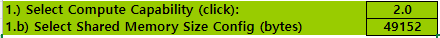

2. 자원 사용량 입력
- 블록 당 스레드 수, 스레드당 레지스터 수, 블록당 공유 메모리 사용량

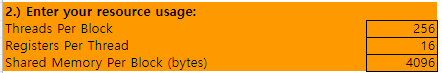

3. 계산 결과

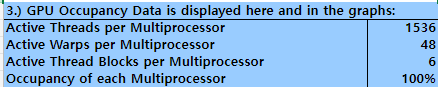

4. 어떤 자원이 occupancy를 제한하는 지 알려줌

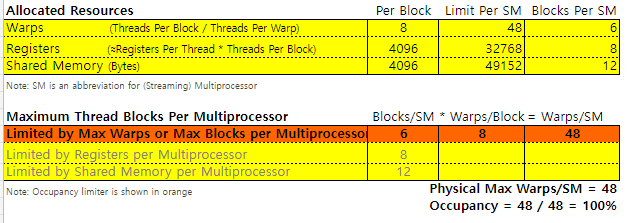

- 그래프도 제공하지만 occupancy calculator는 이론치이므로 실제와는 다를 수 있음
- 만약 스레드당 레지스터 수를 지정하지않으면 NVCC 컴파일러가 자체 결정하기 때문에 Occupancy를 계산할 수 없음
- Nsight Compute를 사용하면 실제 커널이 사용하는 자원의 양과 커널 실행 중 달정하는 Occupancy를 측정할 수 있음
